https://thebinarynotes.com/video-classification-keras-convlstm/

Version History:
- v1.0.0: Same base as "convlstm_v1.1.3", but changes made to classify by heat flux.

In [3]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
 
import os
import cv2
import numpy as np
import matplotlib.pyplot
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
import keras_metrics as km 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [4]:
data_dir = "videos/"
img_height , img_width = 128, 128
seq_len = 10
 
classes = ["class_00", "class_01", "class_02", "class_03",
          "class_04", "class_05", "class_06", "class_07",
          "class_08", "class_09", "class_10", "class_11",
          "class_12", "class_13", "class_14", "class_15",
          "class_16", "class_17", "class_18", "class_19",
          "class_20"]
 
#  Creating frames from videos
 
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list
 
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        if c != "Class 1, small":
            print(c)
            files_list = os.listdir(os.path.join(input_dir, c))
            for f in files_list:
                frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
                if len(frames) == (seq_len):
                    X.append(frames)
                    y = [0]*len(classes)
                    y[classes.index(c)] = 1
                    Y.append(y)
        else:
            pass
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [5]:
X, Y = create_data(data_dir)

class_00
class_01
class_02
class_03
class_04
class_05
class_06
class_07
Defected frame
class_08
class_09
class_10
class_11
class_12
class_13
class_14
class_15
class_16
class_17
class_18
class_19
class_20


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, 
                     data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(21, activation = "softmax"))
 
model.summary()
 
opt = keras.optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

# Prepare callback for training time.
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times=[]
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start=time.time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

earlystop = EarlyStopping(patience=7)
mc = ModelCheckpoint('mdl_weights_flux_1.0.0.hdf5', save_best_only=True, monitor='val_loss', mode='min')
callbacks = [mc, earlystop, time_callback]

In [13]:
history = model.fit(x = X_train, y = y_train, epochs=30, batch_size = 8 , 
                    shuffle=True, validation_split=0.2, callbacks=callbacks,
                    verbose=1)

Train on 1328 samples, validate on 332 samples
Epoch 1/30
1328/1328 [==============================] - 1983s 1s/step - loss: 1.7396 - accuracy: 0.4495 - val_loss: 1.4857 - val_accuracy: 0.5361
Epoch 2/30
1328/1328 [==============================] - 2076s 2s/step - loss: 0.6666 - accuracy: 0.8396 - val_loss: 1.1291 - val_accuracy: 0.6355
Epoch 3/30
1328/1328 [==============================] - 2087s 2s/step - loss: 0.1769 - accuracy: 0.9819 - val_loss: 1.0256 - val_accuracy: 0.6566
Epoch 4/30
1328/1328 [==============================] - 2087s 2s/step - loss: 0.0693 - accuracy: 0.9970 - val_loss: 0.9791 - val_accuracy: 0.6657
Epoch 5/30
1328/1328 [==============================] - 2097s 2s/step - loss: 0.0463 - accuracy: 0.9985 - val_loss: 0.9477 - val_accuracy: 0.6687
Epoch 6/30
1328/1328 [==============================] - 2091s 2s/step - loss: 0.0281 - accuracy: 1.0000 - val_loss: 0.9758 - val_accuracy: 0.6386
Epoch 7/30
1328/1328 [==============================] - 2092s 2s/step - loss:

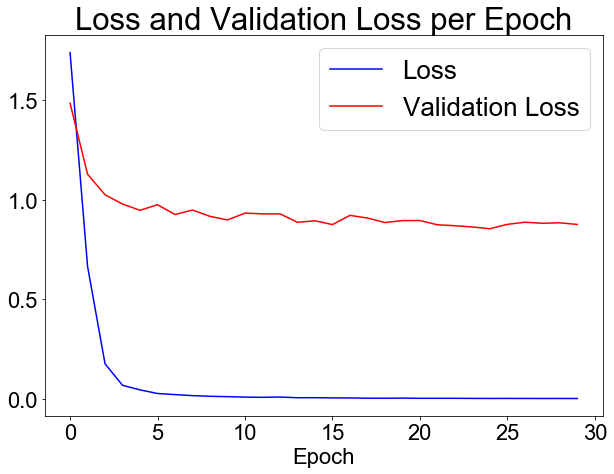

In [14]:
matplotlib.pyplot.figure(figsize=(10,7))
matplotlib.pyplot.rcParams["font.family"] = "Arial"
matplotlib.pyplot.rcParams.update({'font.size': 22})
matplotlib.pyplot.plot(history.history['loss'], label='Loss', color='blue');
matplotlib.pyplot.plot(history.history['val_loss'], label='Validation Loss', color='red');
matplotlib.pyplot.xlabel('Epoch');
matplotlib.pyplot.rcParams.update({'font.size': 26})
matplotlib.pyplot.title('Loss and Validation Loss per Epoch')
matplotlib.pyplot.legend();
matplotlib.pyplot.savefig('convlstm_flux_1.0.0_loss.png')

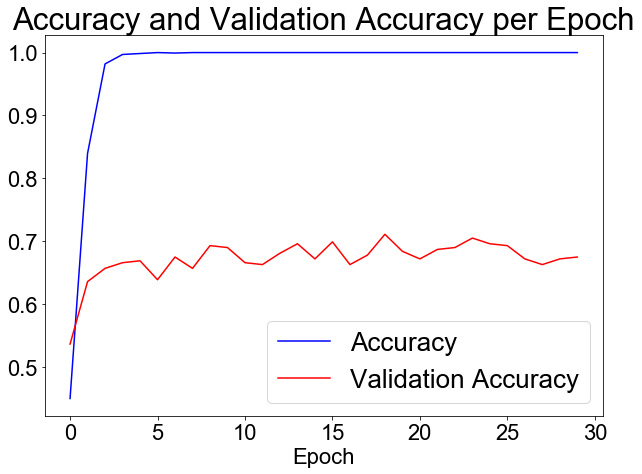

In [15]:
matplotlib.pyplot.figure(figsize=(10,7))
matplotlib.pyplot.rcParams["font.family"] = "Arial"
matplotlib.pyplot.rcParams.update({'font.size': 22})
matplotlib.pyplot.plot(history.history['accuracy'], label='Accuracy', color='blue');
matplotlib.pyplot.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red');
matplotlib.pyplot.xlabel('Epoch');
matplotlib.pyplot.rcParams.update({'font.size': 26})
matplotlib.pyplot.title('Accuracy and Validation Accuracy per Epoch')
matplotlib.pyplot.legend();
matplotlib.pyplot.savefig('convlstm_flux_1.0.0_acc.png')

In [16]:
times = time_callback.times
print("Total time: ", np.sum(times))
print("Average time: ", np.sum(times)/len(times))

Total time:  62652.76015877724
Average time:  2088.425338625908


In [17]:
model.save("convlstm_flux_1.0.0.h5")

In [18]:
loaded_model = load_model("convlstm_flux_1.0.0.h5")

In [19]:
y_pred = loaded_model.predict(X_test)

In [20]:
y_pred_report = np.argmax(y_pred, axis = 1)
y_test_report = np.argmax(y_test, axis = 1)

In [21]:
print(classification_report(y_test_report, y_pred_report))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        23
           3       0.83      1.00      0.91        24
           4       1.00      0.77      0.87        22
           5       0.64      0.91      0.75        23
           6       0.52      0.86      0.65        14
           7       0.70      0.54      0.61        13
           8       0.80      0.55      0.65        22
           9       0.80      0.63      0.71        19
          10       1.00      0.57      0.73        21
          11       0.56      0.74      0.64        19
          12       0.50      0.59      0.54        17
          13       0.88      0.70      0.78        20
          14       0.83      0.79      0.81        19
          15       0.71      0.79      0.75        19
          16       0.69      0.52      0.59        21
          17       0.33    

In [22]:
matrix = confusion_matrix(y_test_report, y_pred_report)

In [23]:
print(matrix)

[[22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  5 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 21  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  2  7  1  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  5  3 12  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  6  1  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  1 12  4  2  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  1  0  0 14  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  5 10  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  5 14  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  2 15  0  0  0  0  0  0]
 [ 0  0  0

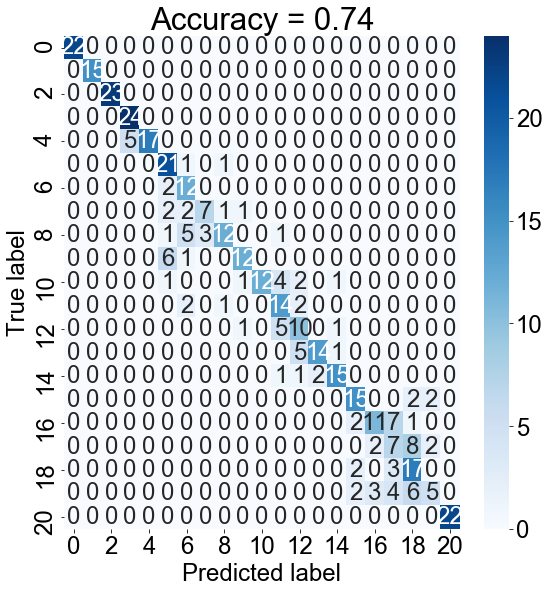

In [27]:
figure = matplotlib.pyplot.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True,cmap=matplotlib.pyplot.cm.Blues,
           annot_kws={"size": 24}, fmt='d')
matplotlib.pyplot.tight_layout()
matplotlib.rcParams.update({'font.size': 26})
matplotlib.pyplot.title("Accuracy = 0.74")
matplotlib.rcParams.update({'font.size': 24})
matplotlib.pyplot.ylabel('True label')
matplotlib.pyplot.xlabel('Predicted label')
matplotlib.pyplot.savefig('conmatrix_convlstm_flux_1.0.0.png',bbox_inches='tight')
matplotlib.pyplot.show()

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [26]:
output_file = open(r"output_convlstm_flux_1.0.0.txt", "w")

output_file.write("loss\n")
for i in range(len(loss)):
    output_file.write(str(loss[i]))
    output_file.write("\n")
output_file.write("\nval_loss\n")
for i in range(len(val_loss)):
    output_file.write(str(val_loss[i]))
    output_file.write("\n")
output_file.write("\naccuracy\n")
for i in range(len(accuracy)):
    output_file.write(str(accuracy[i]))
    output_file.write("\n")
output_file.write("\nval_accuracy\n")
for i in range(len(val_accuracy)):
    output_file.write(str(val_accuracy[i]))
    output_file.write("\n")
    
output_file.close()